<a href="https://colab.research.google.com/github/mashdas/time_series/blob/master/temperature_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
##Fetching ze data
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-05-29 10:28:48--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.03s   

2020-05-29 10:28:48 (2.39 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



In [0]:
import csv
time_stamps=[]
temps=[]

with open("/tmp/daily-min-temperatures.csv") as f:
  reader=csv.reader(f,delimiter=',')
  next(reader)
  stamp=0
  for row in reader:
    temps.append(float(row[1]))
    time_stamps.append(stamp)
    stamp+=1
    

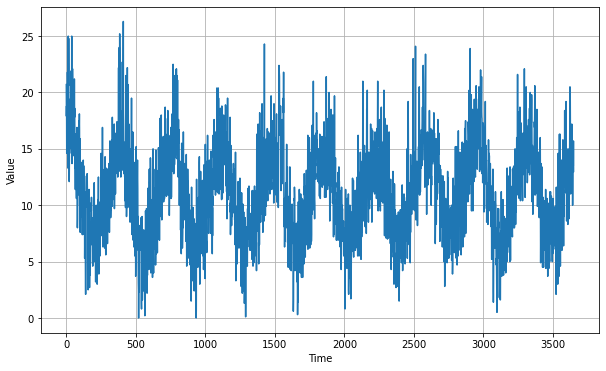

In [17]:
series=np.array(temps)
time=np.array(time_stamps)
plt.figure(figsize=(10,6))
plot_series(time,series)

In [0]:
##Splitting traning and testing data
split=2500
window_size=64
batch_size=256
x_train=series[:split]
time_train=time[:split]
x_valid=series[split:]
time_valid=time[split:]

In [0]:
import tensorflow as tf

In [0]:
def transform(series,window_size,batch_size,shuffle_buffer):
  series=tf.expand_dims(series,axis=-1)
  dataset=tf.data.Dataset.from_tensor_slices(series)
  dataset=dataset.window(window_size+1,shift=1,drop_remainder=True)
  dataset=dataset.flat_map(lambda x:x.batch(window_size+1))
  dataset=dataset.shuffle(shuffle_buffer).map(lambda x:(x[:-1],x[-1]))
  return dataset.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model,series,window_size,batch_size):
  series=tf.expand_dims(series,axis=-1)
  dataset=tf.data.Dataset.from_tensor_slices(series)
  dataset=dataset.window(window_size,shift=1,drop_remainder=True)
  dataset=dataset.flat_map(lambda x:x.batch(window_size))
  dataset=dataset.batch(batch_size).prefetch(1)
  forecast=model.predict(dataset)
  return forecast

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(1)
np.random.seed(1)
train_set=transform(series,window_size,batch_size,1000)

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D,Dense,LSTM,Lambda

In [30]:
model=Sequential()
model.add(Conv1D(32,5,strides=1,padding="causal",activation="relu",input_shape=[None,1]))
model.add(LSTM(64,return_sequences=True))
model.add(LSTM(64,return_sequences=True))
model.add(Dense(30,activation="relu"))
model.add(Dense(10,activation="relu"))
model.add(Dense(1))
model.add(Lambda(lambda x:x*400))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          24832     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1950      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

In [31]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
121/121 [==============================] - 4s 36ms/step - loss: 3.7390 - mae: 4.2149 - lr: 1.0000e-08
Epoch 2/100
121/121 [==============================] - 4s 35ms/step - loss: 3.4654 - mae: 3.9370 - lr: 1.1220e-08
Epoch 3/100
121/121 [==============================] - 4s 36ms/step - loss: 3.3235 - mae: 3.7929 - lr: 1.2589e-08
Epoch 4/100
121/121 [==============================] - 4s 35ms/step - loss: 3.2355 - mae: 3.7034 - lr: 1.4125e-08
Epoch 5/100
121/121 [==============================] - 4s 35ms/step - loss: 3.1613 - mae: 3.6284 - lr: 1.5849e-08
Epoch 6/100
121/121 [==============================] - 4s 36ms/step - loss: 3.0891 - mae: 3.5557 - lr: 1.7783e-08
Epoch 7/100
121/121 [==============================] - 4s 36ms/step - loss: 3.0181 - mae: 3.4843 - lr: 1.9953e-08
Epoch 8/100
121/121 [==============================] - 4s 36ms/step - loss: 2.9483 - mae: 3.4143 - lr: 2.2387e-08
Epoch 9/100
121/121 [==============================] - 4s 36ms/step - loss: 2.8824 - mae

(1e-08, 0.0001, 0.0, 60.0)

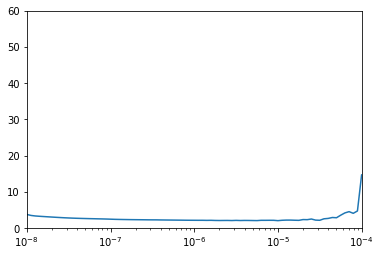

In [32]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [35]:
tf.keras.backend.clear_session()
tf.random.set_seed(1)
np.random.seed(1)
train_set = transform(x_train, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
25/25 [==============================] - 3s 123ms/step - loss: 3.5354 - mae: 4.0071
Epoch 2/150
25/25 [==============================] - 3s 128ms/step - loss: 2.4205 - mae: 2.8818
Epoch 3/150
25/25 [==============================] - 3s 128ms/step - loss: 2.5028 - mae: 2.9662
Epoch 4/150
25/25 [==============================] - 3s 128ms/step - loss: 2.3140 - mae: 2.7731
Epoch 5/150
25/25 [==============================] - 3s 131ms/step - loss: 2.2194 - mae: 2.6776
Epoch 6/150
25/25 [==============================] - 3s 128ms/step - loss: 2.2720 - mae: 2.7326
Epoch 7/150
25/25 [==============================] - 3s 130ms/step - loss: 2.2465 - mae: 2.7070
Epoch 8/150
25/25 [==============================] - 3s 132ms/step - loss: 2.2224 - mae: 2.6824
Epoch 9/150
25/25 [==============================] - 3s 127ms/step - loss: 2.2715 - mae: 2.7310
Epoch 10/150
25/25 [==============================] - 3s 130ms/step - loss: 2.2148 - mae: 2.6730
Epoch 11/150
25/25 [===================

In [0]:
rnn_forecast = model_forecast(model, series,window_size,batch_size)
rnn_forecast = rnn_forecast[split - window_size:-1, -1, 0]

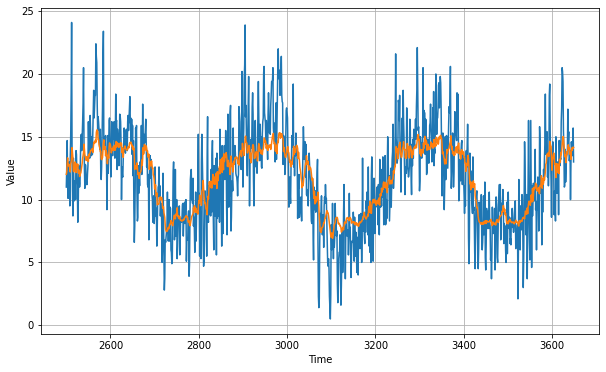

In [47]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [48]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

2.0112302